### **Fine-Tuning Compact Bert Models for Fake News Challenge 1 with ONE EPOCH**

In this notebook we investigate how we can leverage compact BERT models for stance detection task in Fake News Challenge 1


*Note: This notebook was run on Google Colab Pro's TPU runtime settings. We select the Bert model then set the batch size hyper-parameter (16,32,64) for training*

## I. Model Setup

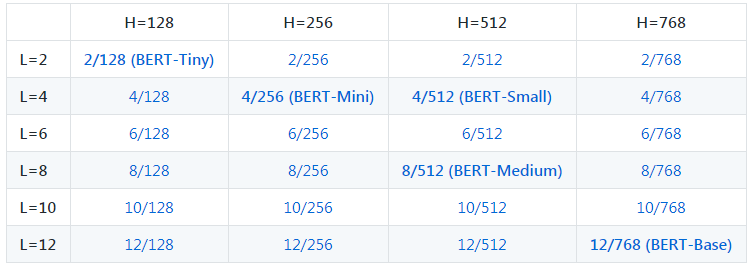





We are going to use BERT-Tiny to build our base model.

In [1]:
!pip install -q "tqdm>=4.36.1"
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow-io==0.15.0 
!pip install -q tf-models-official==2.3.0

import numpy as np
import pandas as pd
import csv
import random
import joblib
import math
from collections import OrderedDict
from csv import DictReader
from datetime import datetime
import json
import warnings
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from  IPython import display
from matplotlib import pyplot as plt

from tqdm import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


import tensorflow_io as tfio
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


In [2]:
#Get Bert Model from these links
#BERT-Tiny 2/128: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-128_A-2.zip
#BERT-Mini 4/256: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-4_H-256_A-4.zip
#BERT-Small 4/512: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-4_H-512_A-8.zip
#BERT-Medium 8/512: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-512_A-8.zip
#BERT-Large 12/768: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-768_A-12.zip

#Bert 4/128: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-4_H-128_A-2.zip
#Bert 6/128: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-6_H-128_A-2.zip
#Bert 8/128: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-128_A-2.zip
#Bert 10/128:https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-10_H-128_A-2.zip
#Bert 12/128:https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-128_A-2.zip

#Bert 2/256:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-256_A-4.zip
#Bert 6/256:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-6_H-256_A-4.zip
#Bert 8/256:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-256_A-4.zip
#Bert 10/256: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-10_H-256_A-4.zip
#Bert 12/256: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-256_A-4.zip

#Bert 2/512:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-512_A-8.zip
#Bert 6/512:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-6_H-512_A-8.zip
#Bert 10/512: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-10_H-512_A-8.zip
#Bert 12/512: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-12_H-512_A-8.zip

#Bert 2/768:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-768_A-12.zip
#Bert 4/768:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-4_H-768_A-12.zip
#Bert 6/768:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-6_H-768_A-12.zip
#Bert 8/768:  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-8_H-768_A-12.zip
#Bert 10/768: https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-10_H-768_A-12.zip

#========================================
#remove old model
!rm *.zip
!rm bert_config.json
!rm bert_model.ckpt.data-00000-of-00001
!rm bert_model.ckpt.index
!rm vocab.txt
!rm model.png

#Download Bert model
!wget https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-128_A-2.zip
!unzip uncased_L-2_H-128_A-2.zip

#set Hyper-Parameters for model training
epochs = 1
batch_size = 64

learning_rate =2e-5
eval_batch_size= 16
SEQUENCE_LENGTH = 256
SPLIT_POINT = 40000




rm: cannot remove 'model.png': No such file or directory
--2020-12-06 03:35:45--  https://storage.googleapis.com/bert_models/2020_02_20/uncased_L-2_H-128_A-2.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529104 (16M) [application/zip]
Saving to: ‘uncased_L-2_H-128_A-2.zip’

uncased_L-2_H-128_A 100%[===================>]  15.76M  55.3MB/s    in 0.3s    

2020-12-06 03:35:45 (55.3 MB/s) - ‘uncased_L-2_H-128_A-2.zip’ saved [16529104/16529104]

Archive:  uncased_L-2_H-128_A-2.zip
  inflating: bert_model.ckpt.data-00000-of-00001  
  inflating: bert_config.json        
  inflating: vocab.txt               
  inflating: bert_model.ckpt.index   


## II. DATA PROCESS

### a. Download data 
There are 2 set of csv files. 
1.   Training set (train_bodies.csv and train_stances.csv)
2.   Testing set (test_bodies.csv and test_stances.csv)



In [3]:
#download train data
!rm -rf data
!git clone https://github.com/tom9ng/data.git

#Remove previous processed train data
!rm pickel_data_test
!rm pickel_date_train


Cloning into 'data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
rm: cannot remove 'pickel_date_train': No such file or directory


In [4]:
class FakeNewsDataset():
    #read in csv file
    def _read_data(self, csv_file):
      rows_list = []
      with open(csv_file, "r", encoding='utf-8') as table:
          r = DictReader(table)
          for line in r:
              rows_list.append(line)
      return rows_list

    #create dictionary of stances and articles
    def _process_news(self, stances, articles):
      articles_dict = dict()
      # make the body ID an integer value
      for s in stances: 
          s['Body ID'] = int(s['Body ID'])

      # copy all bodies into a dictionary
      for article in articles:
          articles_dict[int(article['Body ID'])] = article['articleBody']

      return stances, articles_dict

    #convert text to lower case
    def _lower_case(self,inputs):
        split_inputs = inputs.strip().split(" ")
        for idx, sentence in enumerate(split_inputs):
            split_inputs[idx] = sentence.lower()
        lower_outputs = " ".join(split_inputs)

        return lower_outputs
    # create data pickle
    def create_data_pickle(self, data_type=None):
        #read csv files of bodies and stances
        csv_bodies = "data/" + data_type + "_bodies.csv"
        csv_stances = "data/" + data_type + "_stances.csv"

        stances_list = self._read_data(csv_stances)
        articles_list = self._read_data(csv_bodies)
        #get headlines and articles
        headlines_list, articles_list = self._process_news(stances_list, articles_list)

        stance_labels_list = ['unrelated', 'agree', 'disagree', 'discuss']
        self.stance_counter_dict = None
        if data_type== "train":
          self.stance_counter_dict = OrderedDict({'unrelated':0,'agree':0,'disagree':0,'discuss':0})
          self.total_articles = len(articles_list)
          self.total_stances = len(headlines_list)
        total_data = []
        for h in headlines_list:
            headline = h['Headline']
            headline = self._lower_case(headline)

            body = articles_list[h['Body ID']]
            body = [text for text in body.strip().split('\n') if len(text.strip()) > 0]

            body_context = ""
            for text in body:
                if text == body[-1]:
                    body_context += text
                    break
                body_context += text + ' eop '
            body_context.strip()
            body_context = self._lower_case(body_context)

            label = str(stance_labels_list.index(h['Stance']))

            if data_type == "train":
                self.stance_counter_dict[h['Stance']] += 1

            total_data.append([headline, body_context, label])
                     
        # Save file     
        name= "pickel_data_" + data_type 
        with open(name, "wb") as fwb_handle:
            joblib.dump(total_data, fwb_handle)

        return len(total_data)


We load and process these csv files then save the data into pickle files for processing later

In [5]:
fnc_dataset = FakeNewsDataset()
#process training csvs
train_data_size = fnc_dataset.create_data_pickle("train")
#get Data exploration
stances_counter = fnc_dataset.stance_counter_dict
total_stances = fnc_dataset.total_stances
total_articles = fnc_dataset.total_articles

print("Total articles: {} ".format(total_articles))
print("Total stances: {}".format(total_stances))
print(stances_counter)
#process test csvs
test_data_size = fnc_dataset.create_data_pickle("test")
del fnc_dataset

Total articles: 1683 
Total stances: 49972
OrderedDict([('unrelated', 36545), ('agree', 3678), ('disagree', 840), ('discuss', 8909)])


### b.Extraction 

We are going to process the pickle files for Bert inputs

In [6]:
class FakeNewsDataProcessor():
	def __init__(self, tokenizer,data_type="train"):
		self.data_type = data_type
		self.tokenizer = tokenizer
		self.label_list = ["0", "1", "2", "3"]
		#read data 		
		self.model_data = self._read_pickle('pickel_data_' + data_type, True)
		#process inputs from pickle file
		self.model_features = self._process_input_features(self.model_data, data_type)

	def get_model_inputs_in_batch(self, start_index, batch_size, set_type="train"):
		#bert inputs
		input_ids = []
		input_masks = []
		segment_ids = []
		label_ids = []
		#loop through data features and convert to single feature
		for index, feature in enumerate(self.model_features[start_index * batch_size:batch_size * (start_index + 1)]):
			feature = self._convert_single_example(start_index * batch_size + index, feature, self.label_list, SEQUENCE_LENGTH, self.tokenizer)

			input_ids.append(feature.input_ids)
			input_masks.append(feature.input_mask)
			segment_ids.append(feature.segment_ids)
			label_ids.append(feature.label_id)

		return [input_ids, input_masks, segment_ids, label_ids]

	#read pickle data
	def _read_pickle(self, data_pickle, shuffle=False):
		with open(data_pickle, "rb") as frb_handle:
			total_data = joblib.load(frb_handle)	 
			return total_data

	#process all input features
	def _process_input_features(self, data_inputs, data_type):
		features = []
		#loop through data inputs
		for (i, input_data) in enumerate(data_inputs):
			guid = "%s-%d" % (data_type, i + 1)
			text_a = bert.tokenization.convert_to_unicode(input_data[0])
			text_b = bert.tokenization.convert_to_unicode(input_data[1])
			label = bert.tokenization.convert_to_unicode(input_data[2])
			features.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))

		return features
  #==============================================================================================
  #This function and its related classes is adapted from Google Research's BERT model source code
	#https://github.com/google-research/bert
	def _convert_single_example(self,ex_index, example, label_list, max_seq_length,tokenizer):

		if isinstance(example, PaddingInputExample):
			return InputFeatures(
				input_ids=[0] * max_seq_length,
				input_mask=[0] * max_seq_length,
				segment_ids=[0] * max_seq_length,
				label_id=0,
				is_real_example=False)

		label_map = {}
		for (i, label) in enumerate(label_list):
			label_map[label] = i

		tokens_a = tokenizer.tokenize(example.text_a)
		tokens_b = None
		if example.text_b:
			tokens_b = tokenizer.tokenize(example.text_b)

		if tokens_b:

			self._truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
		else:

			if len(tokens_a) > max_seq_length - 2:
				tokens_a = tokens_a[0:(max_seq_length - 2)]

		tokens = []
		segment_ids = []
		tokens.append("[CLS]")
		segment_ids.append(0)
		for token in tokens_a:
			tokens.append(token)
			segment_ids.append(0)
		tokens.append("[SEP]")
		segment_ids.append(0)

		if tokens_b:
			for token in tokens_b:
				tokens.append(token)
				segment_ids.append(1)
			tokens.append("[SEP]")
			segment_ids.append(1)

		input_ids = tokenizer.convert_tokens_to_ids(tokens)

		input_mask = [1] * len(input_ids)

		while len(input_ids) < max_seq_length:
			input_ids.append(0)
			input_mask.append(0)
			segment_ids.append(0)

		assert len(input_ids) == max_seq_length
		assert len(input_mask) == max_seq_length
		assert len(segment_ids) == max_seq_length

		label_id = label_map[example.label]

		feature = InputFeatures(
			input_ids=input_ids,
			input_mask=input_mask,
			segment_ids=segment_ids,
			label_id=label_id,
			is_real_example=True)
		return feature

	def _truncate_seq_pair(self,tokens_a, tokens_b, max_length):
		while True:
			total_length = len(tokens_a) + len(tokens_b)
			if total_length <= max_length:
				break
			if len(tokens_a) > len(tokens_b):
				tokens_a.pop()
			else:
				tokens_b.pop()
		
class PaddingInputExample(object):
	"""Fake example
	"""

class InputExample(object):

	def __init__(self, guid, text_a, text_b=None, label=None):
		self.guid = guid
		self.text_a = text_a
		self.text_b = text_b
		self.label = label

class InputFeatures(object):
	def __init__(self,
							 input_ids,
							 input_mask,
							 segment_ids,
							 label_id,
							 is_real_example=True):

		self.input_ids = input_ids
		self.input_mask = input_mask
		self.segment_ids = segment_ids
		self.label_id = label_id
		self.is_real_example = is_real_example


In [7]:
#load tokenizer with downloaded vocab file
tokenizer = bert.tokenization.FullTokenizer(vocab_file="vocab.txt",do_lower_case=True)
#process train data pickle to 
data_processor =FakeNewsDataProcessor(tokenizer,"train")
bert_encode_data = data_processor.get_model_inputs_in_batch(0,train_data_size, "train")


Data splitup: 80/20 for training and validation

In [8]:
#split bert encode data 80/20 into 2 sets (training and validation)
k_val = SPLIT_POINT
k_end = train_data_size-1

#train data
training_data = {
      'input_word_ids': np.array(bert_encode_data[0][0:k_val]),
      'input_mask': np.array(bert_encode_data[1][0:k_val]),
      'input_type_ids': np.array(bert_encode_data[2][0:k_val])}
training_labels = tf.keras.utils.to_categorical(bert_encode_data[3][0:k_val], num_classes=4)

#validation data
val_data = {
      'input_word_ids': np.array(bert_encode_data[0][k_val:k_end]),
      'input_mask': np.array(bert_encode_data[1][k_val:k_end]),
      'input_type_ids': np.array(bert_encode_data[2][k_val:k_end])}

val_labels =  tf.keras.utils.to_categorical(bert_encode_data[3][k_val:k_end], num_classes=4)      



In [9]:
del data_processor
del bert_encode_data

## III. Model construction

### a. Set up Bert model

In [10]:
#Set up BERT model from downloaded checkpoint
#load config file 
config_file = "bert_config.json"
config_dict = json.loads(tf.io.gfile.GFile(config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)


In [11]:
#create bert classifier and bert_encoder from bert_config
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=4)

In [12]:
#restore checkpoint
bert_checkpoint = tf.train.Checkpoint(model=bert_encoder)
bert_checkpoint.restore('bert_model.ckpt')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


### b.Set up parameters

In [13]:

#set up training parameters for model
steps = int(train_data_size / batch_size)
train_steps = steps * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer( learning_rate, num_train_steps=train_steps, num_warmup_steps=warmup_steps)

#loss and metrics
metrics=['accuracy']
loss='categorical_crossentropy'

#compile model
bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)
#summary model
bert_classifier.summary()


Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme [(None, None, 128),  4385920     input_word_ids[0][0]             
                                                                 input_mask[0][0]   

### c. Model Training 

In [14]:
#training bert model
start = datetime.now().replace(microsecond=0)
history = bert_classifier.fit(
      training_data, training_labels,
      validation_data=(val_data, val_labels ),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1)
end = datetime.now().replace(microsecond=0)
print(end-start)


625/625 [==============================] - 197s 316ms/step - loss: 3.5656 - accuracy: 0.3589 - val_loss: 1.1929 - val_accuracy: 0.0716
0:03:20


In [15]:
def show_history(fit_history):
  #model accuracy 
  plt.plot(fit_history.history['accuracy'])
  plt.plot(fit_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  #model loss
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#show training history
if (epochs > 1):
  show_history(history) 

print(history.history)

{'loss': [3.5655550956726074], 'accuracy': [0.3589499890804291], 'val_loss': [1.1929467916488647], 'val_accuracy': [0.07160766422748566]}


In [16]:
#evaluate
total_truth_data= []
total_pred_data = []

total_pred_data_size = int(math.ceil(test_data_size / eval_batch_size))
processor = FakeNewsDataProcessor(tokenizer, "test")

start = datetime.now().replace(microsecond=0)
for i in tqdm(range(total_pred_data_size), mininterval=1):

    bert_encode_test = processor.get_model_inputs_in_batch(i,eval_batch_size, "test")

    pred_data = {
      'input_word_ids': np.array(bert_encode_test[0]),
      'input_mask': np.array(bert_encode_test[1]),
      'input_type_ids': np.array(bert_encode_test[2])}

    results = bert_classifier(pred_data, training=False)

    pred_index = np.argmax(results, axis=-1)
    ground_truth = bert_encode_test[3]

    total_truth_data.extend(ground_truth)
    total_pred_data.extend(pred_index)
    bert_encode_test = None

end = datetime.now().replace(microsecond=0)

print(end-start)

100%|██████████| 1589/1589 [04:05<00:00,  6.46it/s]

0:04:06


### d.F1 Score Report

This report is only for reference. The main evaluation metrics will be FNC-1 score

In [17]:
#f1 score
def f1_score_report(truth_data, pred_data):
  valid_labels = [0,1,2,3]
  scores = dict()
  #get average macro 
  scores['f1-macro'] = f1_score(truth_data, pred_data, labels=valid_labels, average="macro")
  #get classifiction report
  scores['classification_report'] = classification_report(truth_data, pred_data, labels=np.unique(pred_data), digits=3)
  return scores

score_reports = f1_score_report(total_truth_data, total_pred_data)
print("f1-macro : ", score_reports['f1-macro'])
print("classification report: ", score_reports['classification_report'])

f1-macro :  0.034833064870405626
classification report:                precision    recall  f1-score   support

           1      0.075     1.000     0.139      1903

   micro avg      0.075     1.000     0.139      1903
   macro avg      0.075     1.000     0.139      1903
weighted avg      0.075     1.000     0.139      1903



### e. FNC1 Score

Since the FNC-1 dataset is highly unbalanced with respect to class distribution, we won’t use F1 score as our evaluation metrics.  Instead, a hierarchical evaluation metric, FNC score, is introduced by the contest organizers with the goal to balance out the large number of unrelated instances. The new schema  first gives out .25 points if the input article is correctly classified as related or ”unrelated” to a given headline. If it is related, .75 extra points are awarded when the model correctly predicts the headline/article pair as ”agree”, ”disagree”, or ”discuss”.
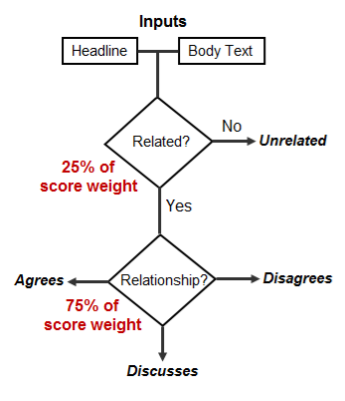

In [18]:
#Contest score fnc-1 score
#These functions are adapted from the official Fake News Challenge's scoring function
# https://github.com/FakeNewsChallenge/fnc-1
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)
    print("Confusion Matrix")
    print_confusion_matrix(cm)
    print("FNC-1 Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


In [19]:
#Print final score
report_score([LABELS[e] for e in total_truth_data],[LABELS[e] for e in total_pred_data])

Confusion Matrix
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |   18349   |     0     |     0     |
-------------------------------------------------------------
| disagree  |     0     |   1903    |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |    697    |     0     |     0     |
-------------------------------------------------------------
| unrelated |     0     |   4464    |     0     |     0     |
-------------------------------------------------------------
FNC-1 Score: 6664.5 out of 22065.0	(30.203942895989123%)


30.203942895989123